In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min

### Preprocessing of data

In [2]:
def preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Preprocess the dataset
    df = df.drop_duplicates()
    df['Total_Purchase'] = df['Quantity'] * df['UnitPrice']

    # Remove outliers based on Total_Purchase
    Q1_total = df['Total_Purchase'].quantile(0.25)
    Q3_total = df['Total_Purchase'].quantile(0.75)
    IQR_total = Q3_total - Q1_total
    lower_bound_total = Q1_total - 1.5 * IQR_total
    upper_bound_total = Q3_total + 1.5 * IQR_total
    df = df[(df['Total_Purchase'] >= lower_bound_total) & (df['Total_Purchase'] <= upper_bound_total)]

    # Remove outliers based on Quantity
    Q1_quantity = df['Quantity'].quantile(0.25)
    Q3_quantity = df['Quantity'].quantile(0.75)
    IQR_quantity = Q3_quantity - Q1_quantity
    lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
    upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity
    df = df[(df['Quantity'] >= lower_bound_quantity) & (df['Quantity'] <= upper_bound_quantity)]

    # Remove outliers based on UnitPrice
    Q1_unit_price = df['UnitPrice'].quantile(0.25)
    Q3_unit_price = df['UnitPrice'].quantile(0.75)
    IQR_unit_price = Q3_unit_price - Q1_unit_price
    lower_bound_unit_price = Q1_unit_price - 1.5 * IQR_unit_price
    upper_bound_unit_price = Q3_unit_price + 1.5 * IQR_unit_price
    df = df[(df['UnitPrice'] >= lower_bound_unit_price) & (df['UnitPrice'] <= upper_bound_unit_price)]

    # Filter based on CustomerID
    df = df[(df['CustomerID'] >= 12000) & (df['CustomerID'] <= 18500)]

    return df

### Customer based clustering

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

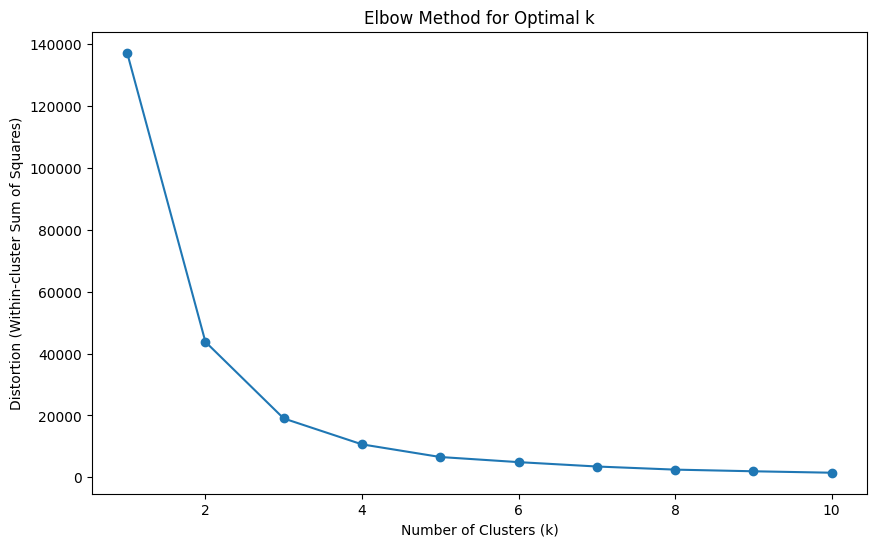

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


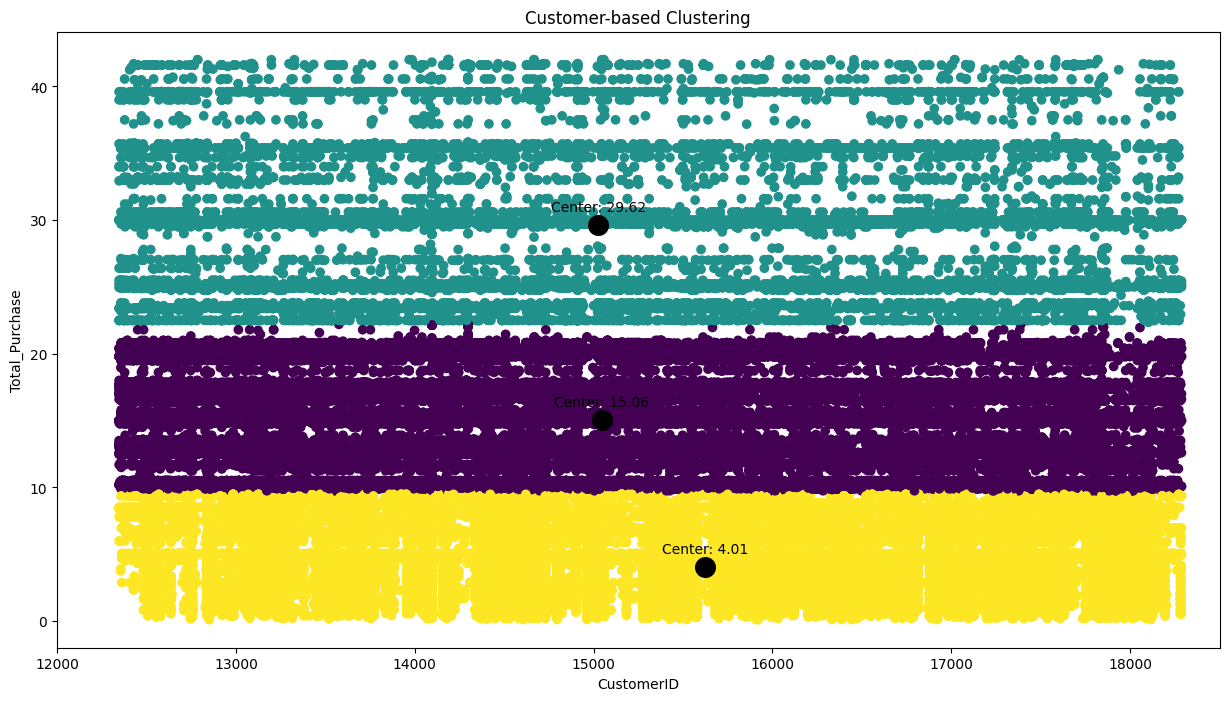

In [3]:
def perform_clustering(df):
    # Select relevant columns for clustering
    customer_data = df[['CustomerID', 'Total_Purchase']].dropna()

    # Standardize the features
    scaler = StandardScaler()
    customer_data_scaled = scaler.fit_transform(customer_data[['Total_Purchase']])

    # Determine the optimal number of clusters (elbow method)
    distortions = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(customer_data_scaled)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Within-cluster Sum of Squares)')
    plt.show()

    # Choose the optimal k value (adjust this based on the elbow point in the graph)
    optimal_k = 3

    # Apply KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

    # Get cluster centers in the scaled space and inverse transform to original scale
    scaled_cluster_centers = kmeans.cluster_centers_
    centers_original_scale = scaler.inverse_transform(scaled_cluster_centers)

    # Plot the clusters and cluster centers
    plt.figure(figsize=(15, 8))
    plt.scatter(customer_data['CustomerID'], customer_data['Total_Purchase'], c=customer_data['Cluster'], cmap='viridis')

    # Annotate the cluster centers
    for i, center_scaled in enumerate(scaled_cluster_centers):
        # Inverse transform the center's Total_Purchase value
        center_val = centers_original_scale[i, 0]

        # Calculate the average CustomerID for the cluster for plotting
        mean_customer_id = customer_data[customer_data['Cluster'] == i]['CustomerID'].mean()

        plt.scatter(mean_customer_id, center_val, c='black', marker='o', s=200)
        plt.annotate(f'Center: {center_val:.2f}', (mean_customer_id, center_val), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title('Customer-based Clustering')
    plt.xlabel('CustomerID')
    plt.ylabel('Total_Purchase')
    plt.xlim(12000, 18500)
    plt.show()

# Usage
file_path = "C:/Users/prase/OneDrive/Documents/INFORMATICS/Project/dataset.csv"
processed_df = preprocess_data(file_path)
perform_clustering(processed_df)


### Geographical clustering

In [4]:
def elbow_method_plot(data, feature_column='Total_Purchase'):
    # Select relevant columns for clustering
    geo_data = data[['Country', feature_column]].dropna()

    # Convert 'Country' to numerical values using label encoding
    geo_data['Country'] = geo_data['Country'].astype('category').cat.codes

    # Standardize the features
    scaler = StandardScaler()
    geo_data_scaled = scaler.fit_transform(geo_data[[feature_column]])

    # Determine the optimal number of clusters (elbow method)
    distortions = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(geo_data_scaled)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Within-cluster Sum of Squares)')
    plt.show()

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

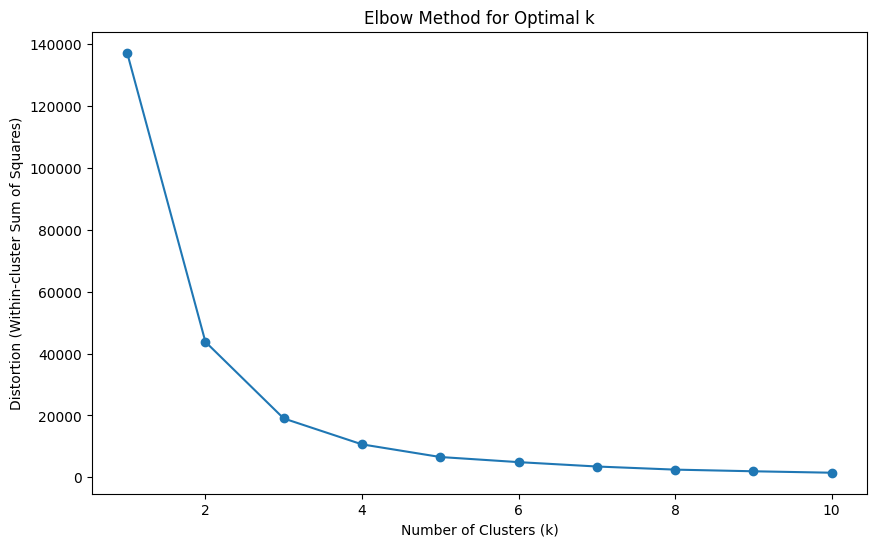

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


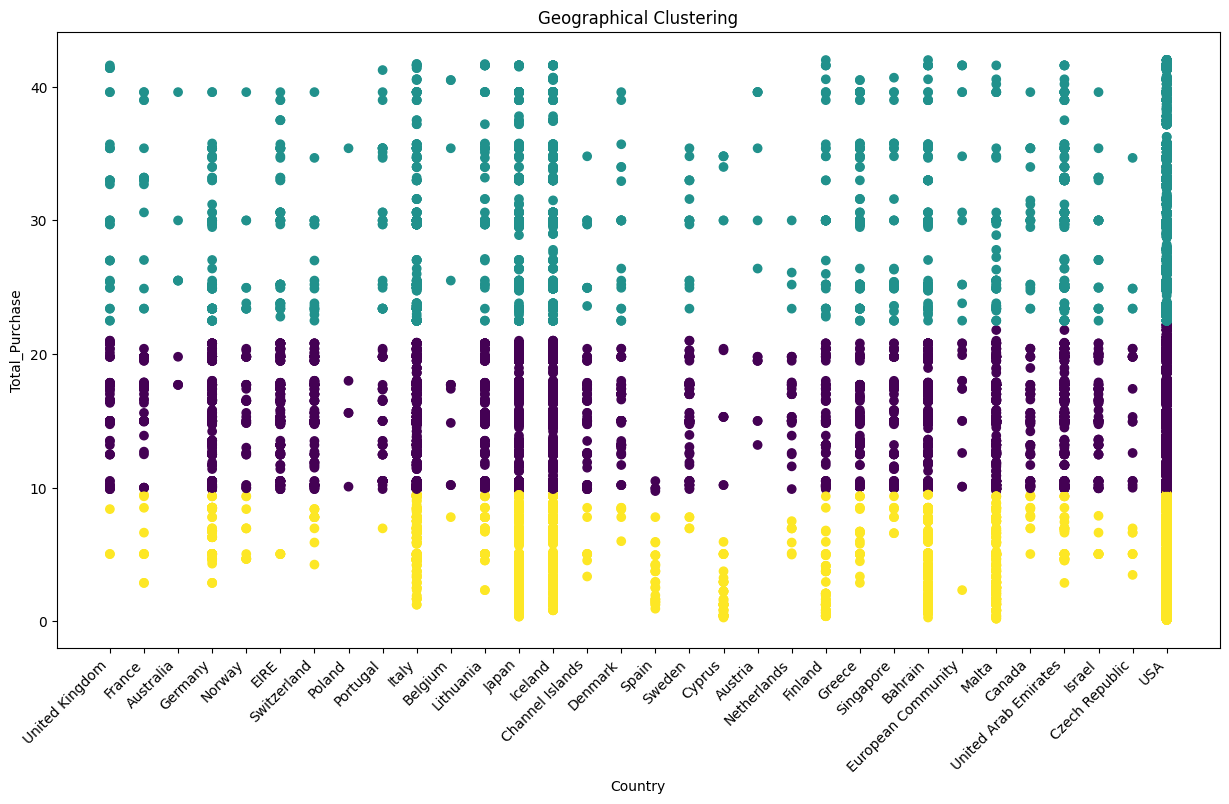

In [5]:
def cluster_and_plot(data, optimal_k, feature_column='Total_Purchase'):
    # Select relevant columns for clustering
    geo_data = data[['Country', feature_column]].dropna()

    # Convert 'Country' to numerical values using label encoding
    geo_data['Country'] = geo_data['Country'].astype('category').cat.codes

    # Standardize the features
    scaler = StandardScaler()
    geo_data_scaled = scaler.fit_transform(geo_data[[feature_column]])

    # Apply KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    geo_data['Cluster'] = kmeans.fit_predict(geo_data_scaled)

    # Get cluster centers in the scaled space and inverse transform to original scale
    scaled_cluster_centers = kmeans.cluster_centers_
    centers_original_scale = scaler.inverse_transform(scaled_cluster_centers)

    # Plot the clusters and cluster centers
    plt.figure(figsize=(15, 8))
    plt.scatter(geo_data['Country'], geo_data[feature_column], c=geo_data['Cluster'], cmap='viridis')

    # Annotate the cluster centers
    for i, center_scaled in enumerate(scaled_cluster_centers):
        # Inverse transform the center's Total_Purchase value
        center_val = centers_original_scale[i, 0]

        # Calculate the average Country for the cluster for plotting
        mean_country = geo_data[geo_data['Cluster'] == i]['Country'].mean()

        
    # Set the x-axis labels to country names
    country_names = data['Country'].unique()
    plt.xticks(np.arange(len(country_names)), country_names, rotation=45, ha='right')

    plt.title('Geographical Clustering')
    plt.xlabel('Country')
    plt.ylabel(feature_column)
    plt.show()

# Load and preprocess data
file_path = "C:/Users/prase/OneDrive/Documents/INFORMATICS/Project/dataset.csv"
df =preprocess_data(file_path)

# Elbow method plot
elbow_method_plot(df)

# Choose the optimal k value (adjust this based on the elbow point in the graph)
optimal_k = 3

# Cluster and plot
cluster_and_plot(df, optimal_k)

### Product based clustering

In [6]:
def elbow_method_plot(data, feature_columns=['Quantity', 'UnitPrice']):
    # Select relevant columns for clustering
    product_data = data[feature_columns].dropna()

    # Standardize the features
    scaler = StandardScaler()
    product_data_scaled = scaler.fit_transform(product_data)

    # Determine the optimal number of clusters (elbow method)
    distortions = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(product_data_scaled)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Within-cluster Sum of Squares)')
    plt.show()

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

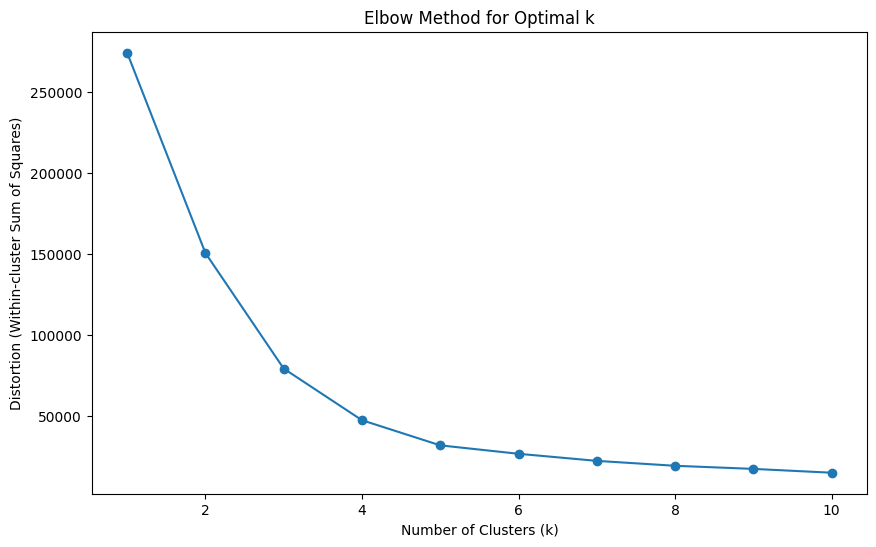

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


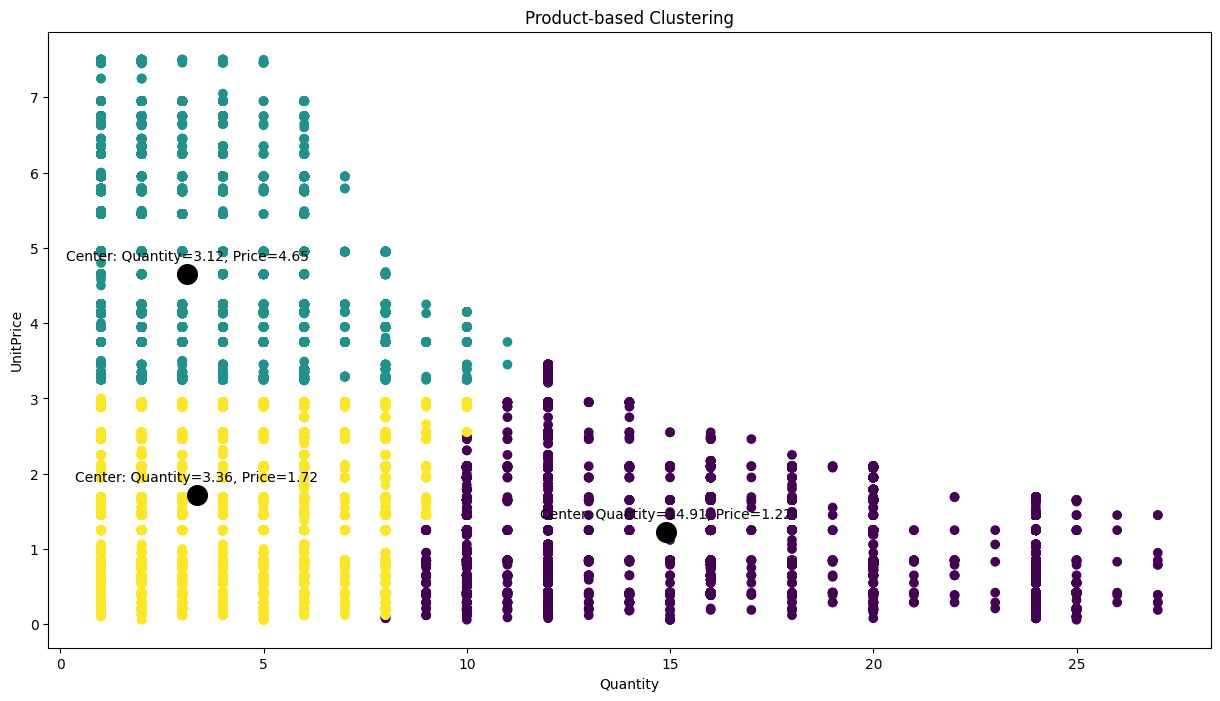

In [7]:
def cluster_and_plot(data, optimal_k, feature_columns=['Quantity', 'UnitPrice']):
    # Select relevant columns for clustering
    product_data = data[feature_columns].dropna()

    # Standardize the features
    scaler = StandardScaler()
    product_data_scaled = scaler.fit_transform(product_data)

    # Apply KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    product_data['Cluster'] = kmeans.fit_predict(product_data_scaled)

    # Get cluster centers in the scaled space and inverse transform to original scale
    scaled_cluster_centers = kmeans.cluster_centers_
    centers_original_scale = scaler.inverse_transform(scaled_cluster_centers)

    # Plot the clusters and cluster centers
    plt.figure(figsize=(15, 8))
    plt.scatter(product_data['Quantity'], product_data['UnitPrice'], c=product_data['Cluster'], cmap='viridis')

    # Annotate the cluster centers
    for i, center_scaled in enumerate(scaled_cluster_centers):
        # Inverse transform the center's Quantity and UnitPrice values
        center_quantity, center_price = centers_original_scale[i, :]

        plt.scatter(center_quantity, center_price, c='black', marker='o', s=200)
        plt.annotate(f'Center: Quantity={center_quantity:.2f}, Price={center_price:.2f}', 
                     (center_quantity, center_price), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Product-based Clustering')
    plt.xlabel('Quantity')
    plt.ylabel('UnitPrice')
    #plt.xlim(0, 81000)
    #plt.ylim(0, 8200)
    plt.show()

# Load and preprocess data
file_path = "C:/Users/prase/OneDrive/Documents/INFORMATICS/Project/dataset.csv"
df =preprocess_data(file_path)

# Elbow method plot
elbow_method_plot(df)

# Choose the optimal k value (adjust this based on the elbow point in the graph)
optimal_k = 3

# Cluster and plot
cluster_and_plot(df, optimal_k, feature_columns=['Quantity', 'UnitPrice'])

### RFM clustering

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

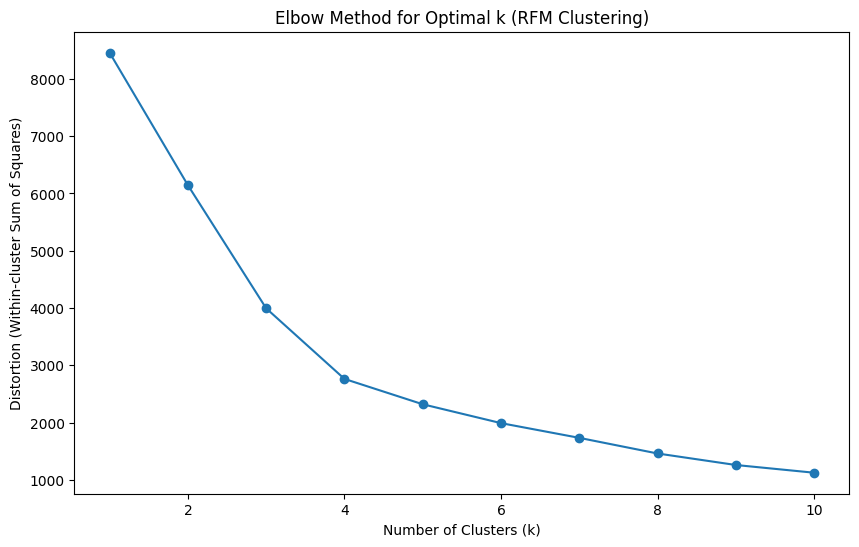

c:\Users\prase\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


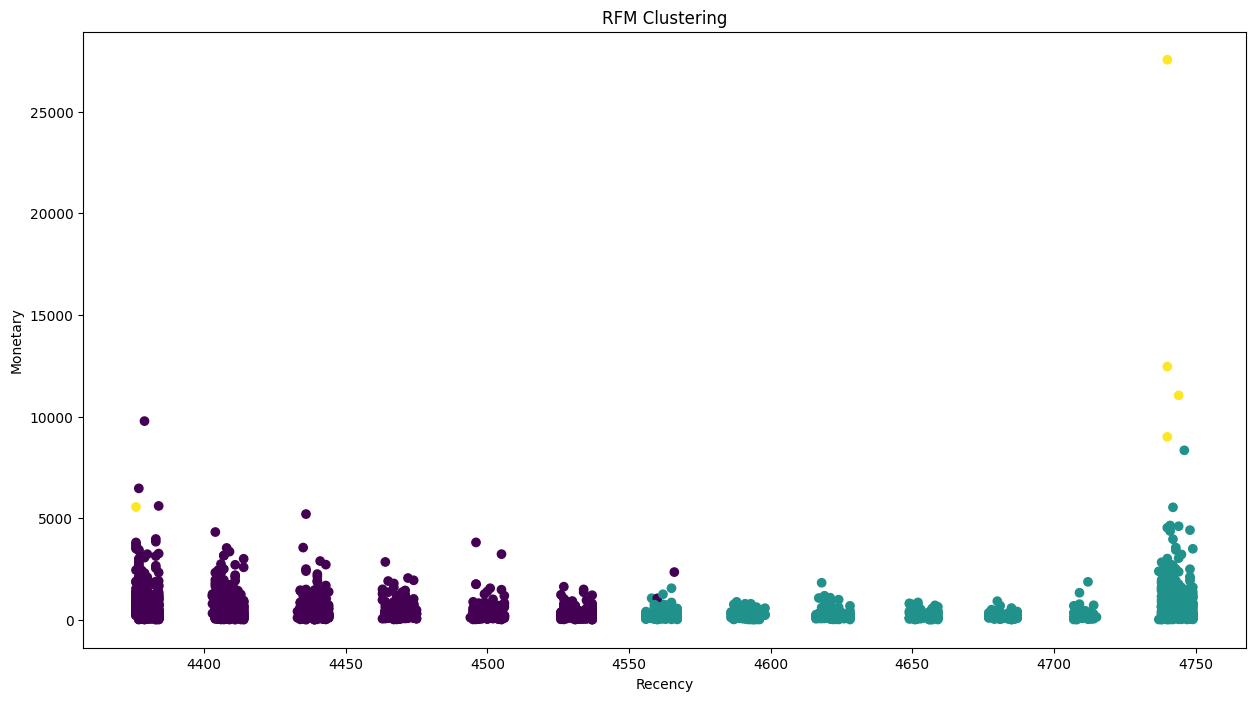

In [8]:
def calculate_rfm(data):
    # Calculate Recency, Frequency, and Monetary values for each customer
    rfm_data = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (pd.to_datetime('now') - pd.to_datetime(x.max())).days,
        'InvoiceNo': 'nunique',
        'Total_Purchase': 'sum'
    }).reset_index()

    # Rename columns
    rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    return rfm_data

def elbow_method_plot(data):
    # Select relevant columns for clustering
    rfm_data = data[['Recency', 'Frequency', 'Monetary']].dropna()

    # Standardize the features
    scaler = StandardScaler()
    rfm_data_scaled = scaler.fit_transform(rfm_data)

    # Determine the optimal number of clusters (elbow method)
    distortions = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(rfm_data_scaled)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal k (RFM Clustering)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Within-cluster Sum of Squares)')
    plt.show()

def cluster_and_plot(data, optimal_k):
    # Select relevant columns for clustering
    rfm_data = data[['Recency', 'Frequency', 'Monetary']].dropna()

    # Standardize the features
    scaler = StandardScaler()
    rfm_data_scaled = scaler.fit_transform(rfm_data)

    # Apply KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    rfm_data['Cluster'] = kmeans.fit_predict(rfm_data_scaled)

    # Plot the clusters
    plt.figure(figsize=(15, 8))
    plt.scatter(rfm_data['Recency'], rfm_data['Monetary'], c=rfm_data['Cluster'], cmap='viridis')
    plt.title('RFM Clustering')
    plt.xlabel('Recency')
    plt.ylabel('Monetary')
    plt.show()

# Load and preprocess data
file_path = "C:/Users/prase/OneDrive/Documents/INFORMATICS/Project/dataset.csv"
df = preprocess_data(file_path)

# Calculate RFM values
rfm_df = calculate_rfm(df)

# Elbow method plot for RFM clustering
elbow_method_plot(rfm_df)

# Choose the optimal k value (adjust this based on the elbow point in the graph)
optimal_k = 3

# Cluster and plot for RFM clustering
cluster_and_plot(rfm_df, optimal_k)